Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

Всего датасет содержит 159 записей. Мы предварительно зарезервировали часть датасета для задания по преодолению бейслайна (baseline). В настоящем задании подразумевается работа с датасетом, содержащим 119 записей.

# 0. Применение полиномиальной регрессии для предсказания непрерывного параметра

Представленный набор данных — это набор данных о семи различных типах рыб, продаваемых в некоторой рыбной лавке. Наша цель заключается в том, чтобы предсказать массу рыбы по каким-то косвенным признакам, известным о рыбе. Сами признаки, быть может, нужно синтезировать из тех, что известны.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки с параметрами, указанными в вашем задании. Используйте стратификацию по колонке <code>Species</code>. Стратификация позволит сохранить доли представленных объектов (по представителям типов рыб) в тренировочной и тестовой выборках.

In [2]:
df = pd.read_csv("fish_train.csv")
X = df.drop(columns='Weight')
Y = df['Weight']

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7, stratify=df['Species'])

Вычислите выборочное среднее колонки <code>Width</code> полученной тренировочной выборки.

In [4]:
np.mean(X_train['Width'])

4.512485263157894

# 1. Построение базовой модели

Избавьтесь от категориальных признаков и обучите модель линейной регрессии (<code>LinearRegression()</code>) на тренировочном наборе данных. Выполните предсказания для тестового набора данных. Оцените модель при помощи метрики <code>r2_score()</code>.

In [5]:
X_train = X_train.drop(columns='Species')
X_test = X_test.drop(columns='Species')
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [6]:
y_pred = model.predict(X_test)

In [7]:
r2 = r2_score(Y_test, y_pred)
r2

0.8759245925717026

# 2. Добавление предварительной обработки признаков.

## Использование PCA

При помощи, например, <code>sns.heatmap()</code>, постройте матрицу корреляций признаков тренировочного набора данных и определите тройку наиболее коррелированных между собой признаков.

<Axes: >

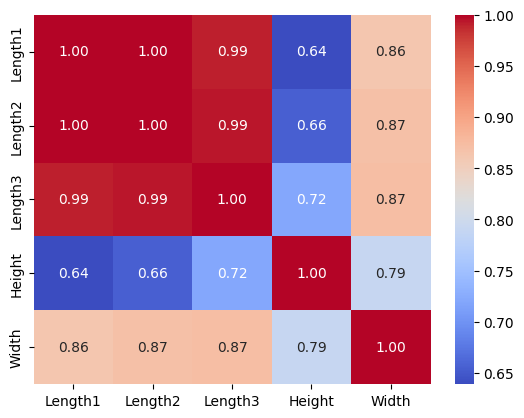

In [8]:
cor_matrix = X_train.corr()
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [9]:
correlation_matrix_np = cor_matrix.to_numpy()
max_corr_indices = []
for i in range(len(correlation_matrix_np)):
    for j in range(i + 1, len(correlation_matrix_np[i])):
        max_corr_indices.append((i, j))

# Сортируем тройки по абсолютным значениям корреляции и берем три с наибольшей корреляцией
sorted_max_corr_indices = sorted(max_corr_indices, key=lambda x: abs(correlation_matrix_np[x[0]][x[1]]), reverse=True)[:3]

# Напечатать тройку наиболее коррелированных признаков
feature_names = X_train.columns
print("Тройка наиболее коррелированных между собой признаков:")
for indices in sorted_max_corr_indices:
    print(feature_names[indices[0]], ",", feature_names[indices[1]])

Тройка наиболее коррелированных между собой признаков:
Length1 , Length2
Length2 , Length3
Length1 , Length3


Линейные модели достаточно плохо реагируют на коррелированные признаки, поэтому от таких признаков имеет смысл избавиться еще до начала обучения.

Для уменьшения количества неинформативных измерений используйте метод главных компонент.

1) Примените метод главных компонент (<code>PCA(n_components=3, svd_solver='full')</code>) для трех найденных наиболее коррелированных признаков.

2) Вычислите долю объясненной дисперсии при использовании только первой главной компоненты.

3) Замените три наиболее коррелированных признака на новый признак <code>Lengths</code>, значения которого совпадают со значениями счетов первой главной компоненты.

In [10]:
from sklearn.decomposition import PCA

top_correlated_features_indices = (0, 1, 2)

pca = PCA(n_components=3, svd_solver='full')

# Обучаем PCA на трех выбранных признаках
pca.fit(X_train.iloc[:, list(top_correlated_features_indices)])

# Преобразуем данные с помощью PCA
pca_scores = pca.transform(X_train.iloc[:, list(top_correlated_features_indices)])

# Вычисляем долю объясненной дисперсии при использовании только первой главной компоненты
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_first_component = explained_variance_ratio[0]
print("Доля объясненной дисперсии первой главной компоненты:", explained_variance_ratio_first_component)

# Заменяем три наиболее коррелированных признака на новый признак "Lengths"
X_train['Lengths'] = pca_scores[:, 0]

# Удаляем старые признаки
X_train.drop(X_train.columns[list(top_correlated_features_indices)], axis=1, inplace=True)

Доля объясненной дисперсии первой главной компоненты: 0.9963067360120653


In [11]:
X_train

,Height,Width,Lengths
51,1.9720,1.1600,-31.652047
34,11.4884,7.7957,10.380682
44,6.8475,2.3265,-24.330982
96,16.3618,6.0900,12.158555
35,8.9262,6.1712,39.453930
...,...,...,...
114,11.0880,4.1440,-6.207243
14,5.2185,3.6260,-10.594615
79,7.0516,4.3350,-2.930005
17,7.6156,4.7716,1.462732


Примените полученное преобразование для тех же признаков в тестовом наборе данных. Обратите внимание, что заново обучать преобразование `PCA` не нужно. Аналогично предыдущему этапу замените три рассмотренных признака на один.

In [12]:
# Преобразуем данные с помощью PCA
pca_scores = pca.transform(X_test.iloc[:, list(top_correlated_features_indices)])
# Заменяем три наиболее коррелированных признака на новый признак "Lengths"
X_test['Lengths'] = pca_scores[:, 0]

# Удаляем старые признаки
X_test.drop(X_test.columns[list(top_correlated_features_indices)], axis=1, inplace=True)
X_test

,Height,Width,Lengths
11,18.0369,6.3063,17.942473
55,7.6800,5.3760,33.039961
25,8.8928,3.2928,-15.009778
6,4.5880,2.9415,-20.363985
59,2.8728,2.0672,-25.526847
84,2.2044,1.1484,-29.050176
112,10.5717,6.3666,13.891913
39,7.5852,4.6354,-0.695005
115,6.9600,4.8960,27.836219
9,11.5200,4.0200,-4.631014


Обучите базовую модель линейной регресси на полученных тренировочных данных, снова выбросив категориальные признаки. Выполните предсказания для тестовых данных, оцените при помощи <code>r2_score()</code>.

In [13]:
model = LinearRegression()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
r2 = r2_score(Y_test, y_pred)
r2

0.8638980776530603

In [14]:
X_train['Width'] = X_train['Width'].apply(lambda x: x ** 3)
np.mean(X_train['Width'])

130.33881727241788

In [15]:
X_train['Height'] = X_train['Height'].apply(lambda x: x ** 3)
X_train['Lengths'] = X_train['Lengths'].apply(lambda x: x ** 3)

Видно, что точность значительно не изменилась.

## Модификация признаков

Постройте графики зависимостей признаков от целевой переменной, например, при помощи <code>sns.pairplot()</code>.

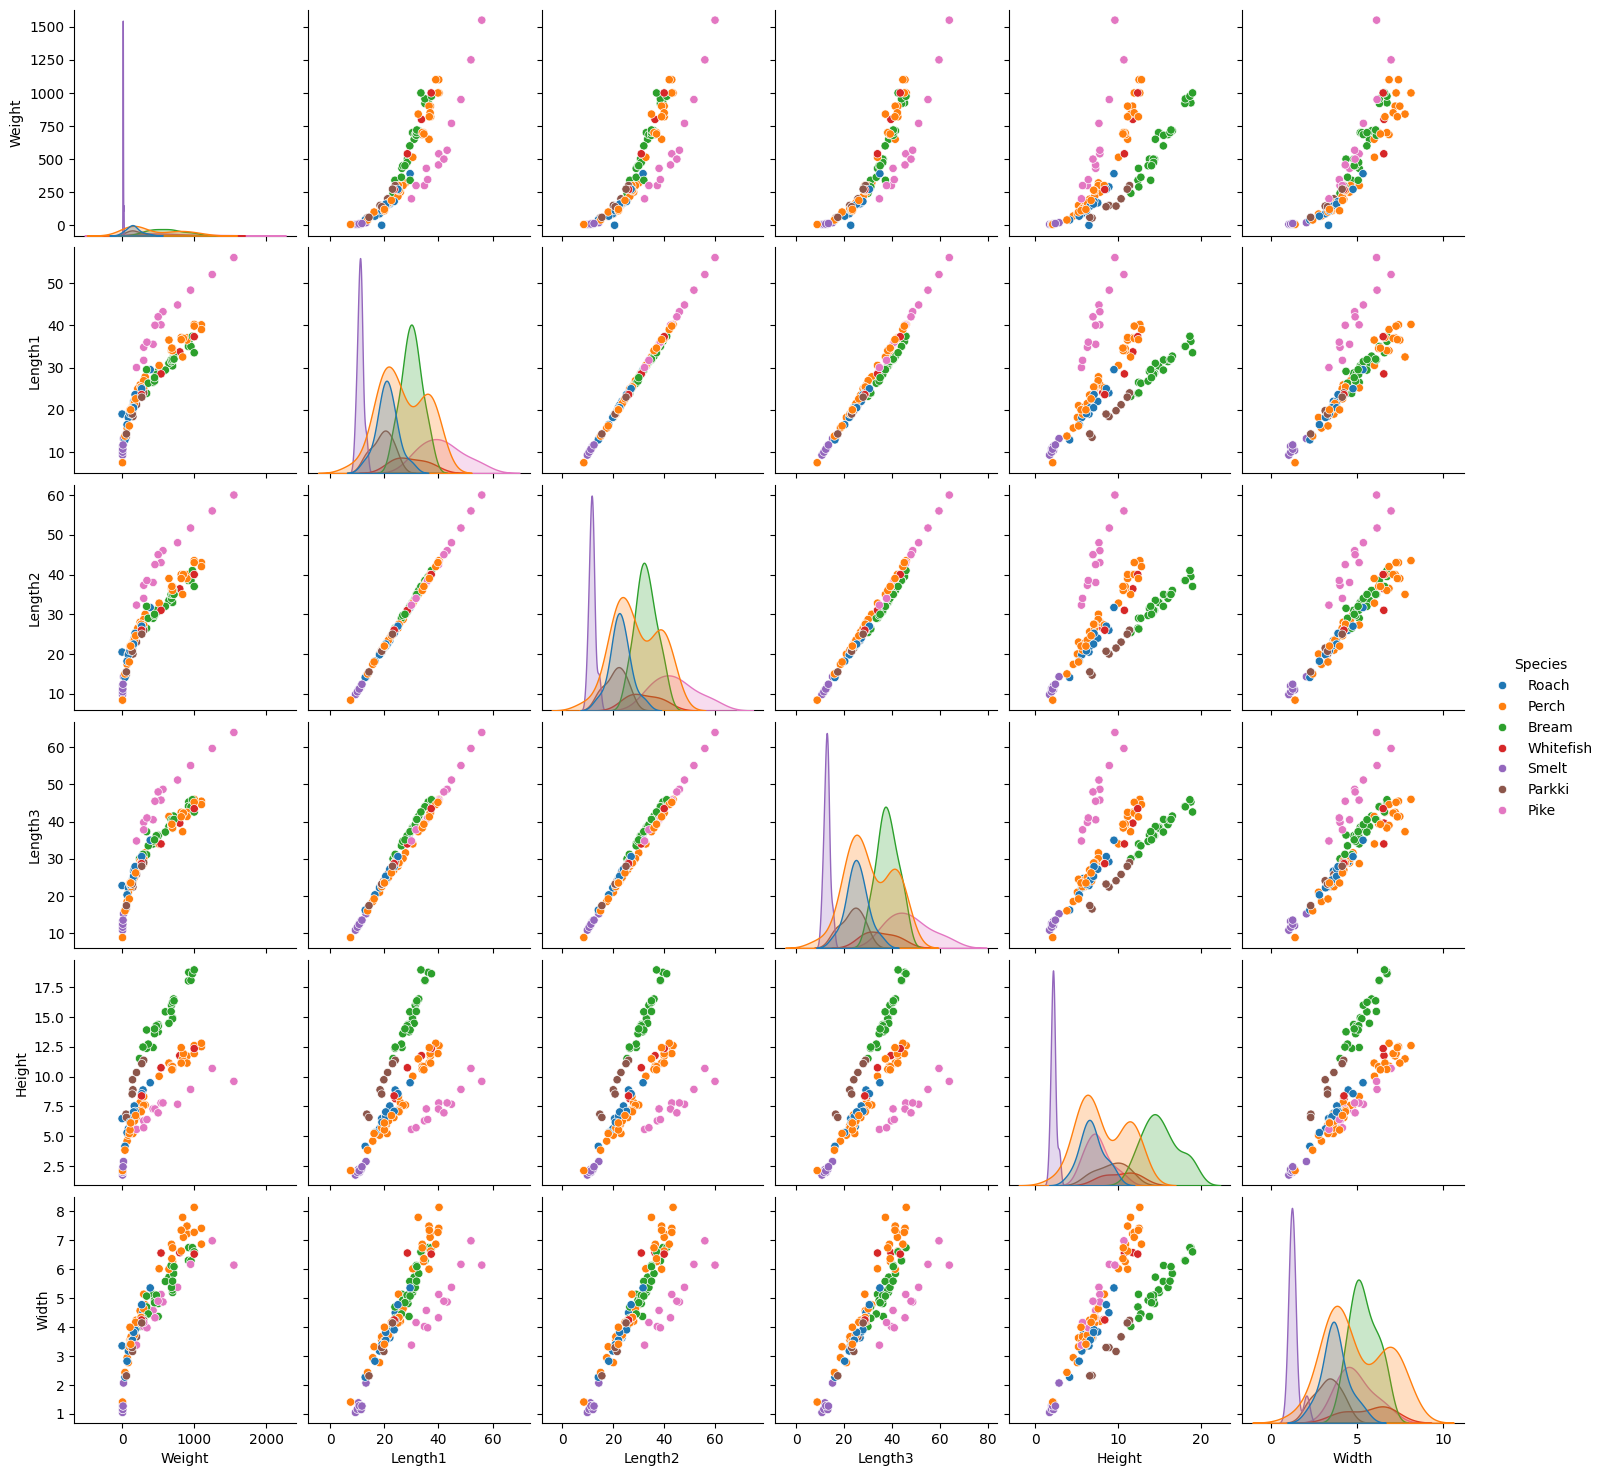

In [16]:
import matplotlib.pyplot as plt
sns.pairplot(df, hue='Species')
plt.show()

Видно, что масса, вообще говоря, нелинейно зависит от остальных параметров. Значит, чтобы линейная модель хорошо справлялась с предсказанием, признаки имеет смысл преобразовать так, чтобы зависимость стала более похожей на линейную. Но как придумать такую зависимость?

Логично предположить, что масса рыбы должна каким-то гладким образом зависеть от остальных параметров, отвечающих так или иначе за размеры. Если впомнить, что масса — это произведение плотности на объем, то

$$
m = \rho \cdot V.
$$

Допустим, что средняя плотность у всех рыб одинаковая, и вспомним, что при гомотетии объем объекта зависит от линейных размеров как куб, тогда получим

$$
m\sim V\sim d^3
$$

Все признаки тренировочного и тестового наборов данных, отвечающие так или иначе за размеры (<code>Height, Width, Lengths</code>), возведите в третью степень, и проверьте, стала ли зависимость массы от этих признаков похожа на линейную.

In [17]:
X_test['Width'] = X_test['Width'].apply(lambda x: x ** 3)
X_test['Height'] = X_test['Height'].apply(lambda x: x ** 3)
X_test['Lengths'] = X_test['Lengths'].apply(lambda x: x ** 3)

Введите выборочное среднее колонки <code>Width</code> тренировочного набора данных после возведения в куб.

In [18]:
np.mean(X_train['Width'])

130.33881727241788

Выберите изображения, соответствующие зависимости <code>Weight</code> от <code>Width</code> до преобразования и после.

Обучите базовую модель линейной регресси на полученных тренировочных данных, снова выбросив категориальные признаки. Выполните предсказания для тестовых данных, оцените при помощи `r2_score()`.

In [19]:
model = LinearRegression()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
r2 = r2_score(Y_test, y_pred)
r2

0.9207852790022393

In [20]:
X_test

,Height,Width,Lengths
11,5867.940377,250.797891,5776.262025
55,452.984832,155.373797,36067.711201
25,703.259448,35.702289,-3381.604562
6,96.576225,25.451100,-8444.778791
59,23.709160,8.833799,-16633.802479
84,10.712016,1.514536,-24515.812494
112,1181.502082,258.061189,2680.934250
39,436.416447,99.600530,-0.335710
115,337.153536,117.361115,21569.035007
9,1528.823808,64.964808,-99.318070


Обратите внимание на то, как такая нехитрая работа с признаками помогла разительно улучшить точность модели!

## Добавление категориальных признаков

Произведите <code>one-hot</code> кодировние категориального признака `Species`, например, с помощью <code>pd.get_dummies()</code>.

Обучите модель линейной регресси на полученных тренировочных данных. Выполните предсказания для тестовых данных, оцените модель при помощи <code>r2_score()</code>.

<b>Примечание</b>: Мы специально использовали стратифицированное разделение, чтобы все значения категориального признака <code>Species</code> присутствовали во всех наборах данных. Но такое возможно не всегда. Про то, как с этим бороться можно почитать, [например, здесь](https://predictivehacks.com/?all-tips=how-to-deal-with-get_dummies-in-train-and-test-dataset).

In [25]:
df_with_dummies = pd.get_dummies(df)
X = df.drop(columns='Weight')
Y = df['Weight']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7, stratify=df['Species'])

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

top_correlated_features_indices = (0, 1, 2)

pca = PCA(n_components=3, svd_solver='full')

# Обучаем PCA на трех выбранных признаках
pca.fit(X_train.iloc[:, list(top_correlated_features_indices)])

# Преобразуем данные с помощью PCA
pca_scores = pca.transform(X_train.iloc[:, list(top_correlated_features_indices)])

# Заменяем три наиболее коррелированных признака на новый признак "Lengths"
X_train['Lengths'] = pca_scores[:, 0]

# Удаляем старые признаки
X_train.drop(X_train.columns[list(top_correlated_features_indices)], axis=1, inplace=True)

# Преобразуем данные с помощью PCA
pca_scores = pca.transform(X_test.iloc[:, list(top_correlated_features_indices)])
# Заменяем три наиболее коррелированных признака на новый признак "Lengths"
X_test['Lengths'] = pca_scores[:, 0]

# Удаляем старые признаки
X_test.drop(X_test.columns[list(top_correlated_features_indices)], axis=1, inplace=True)

X_train['Height'] = X_train['Height'].apply(lambda x: x ** 3)
X_train['Lengths'] = X_train['Lengths'].apply(lambda x: x ** 3)
X_train['Width'] = X_train['Width'].apply(lambda x: x ** 3)

X_test['Height'] = X_test['Height'].apply(lambda x: x ** 3)
X_test['Lengths'] = X_test['Lengths'].apply(lambda x: x ** 3)
X_test['Width'] = X_test['Width'].apply(lambda x: x ** 3)

# Обучаем модель регрессии
model = LinearRegression()
model.fit(X_train, Y_train)

# Делаем предсказания
Y_pred = model.predict(X_test)

# Вычисляем коэффициент детерминации (R^2)
r2 = r2_score(Y_test, Y_pred)

In [26]:
r2

0.9390811929661294

И снова точность возрасла.

Как можно увидеть, после `one-hot` кодирования признаки стали коррелированы. От этого можно избавиться, например, при помощи параметра `drop_first=True`. Заново обучите модель после исправления этого недочета. Выполните предсказания для тестовых данных, оцените модель при помощи <code>r2_score()</code>.

In [27]:
# Создаем дамми-переменные с параметром drop_first=True
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Обучаем модель регрессии
model = LinearRegression()
model.fit(X_train, Y_train)

# Делаем предсказания
Y_pred = model.predict(X_test)

# Оцениваем модель при помощи r2_score
r2 = r2_score(Y_test, Y_pred)
print("Коэффициент детерминации (R^2) после исправления недочета:", r2)

Коэффициент детерминации (R^2) после исправления недочета: 0.9390811929661294


На таком сравнительно небольшом наборе данных, впрочем, разницы мы не видим.